In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

Files already downloaded and verified
Files already downloaded and verified


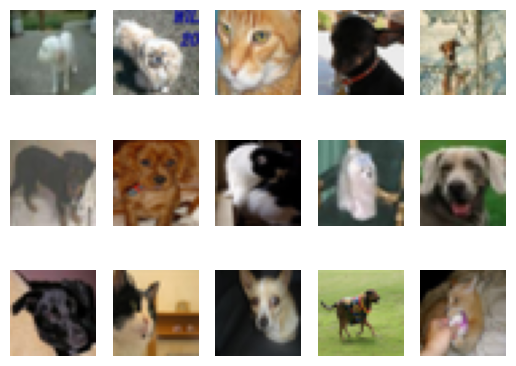

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

In [ ]:
cat_train = 0
dog_train = 0
cat_val = 0
dog_val = 0
cat_test = 0
dog_test = 0

for images, labels in train_loader:
  if labels == 3:
    cat_train = cat_train + 1
  elif labels == 5:
    dog_train = dog_train + 1

for images, labels in val_loader:
  if labels == 3:
    cat_val = cat_val + 1
  elif labels == 5:
    dog_val = dog_val + 1

for images, labels in train_loader:
  if labels == 3:
    cat_test = cat_test + 1
  elif labels == 5:
    dog_test = dog_test + 1

print("cat images in training:" + str(cat_train))
print("dog images in training:" + str(dog_train))
print("cat images in validation:" + str(cat_val))
print("dog images in validation:" + str(dog_val))
print("cat images in testing:" + str(cat_test))
print("dog images in testing:" + str(dog_test))


cat images in training:4018
dog images in training:3982
cat images in validation:982
dog images in validation:1018
cat images in testing:4018
dog images in testing:3982


In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

In [ ]:
for param in small_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])


In [ ]:
small_params =0
large_params = 0

for params in small_net.parameters():
  small_params = small_params + params.numel()

for params in large_net.parameters():
  large_params = large_params+ params.numel()


print("number of small_net parameters:" + str(small_params))

print("number of large_net parameters:" + str(large_params))

number of small_net parameters:386
number of large_net parameters:9705


In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_net(small_net)
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.42675, Train loss: 0.6751564774513245 |Validation err: 0.389, Validation loss: 0.6625499613583088
Epoch 2: Train err: 0.38675, Train loss: 0.6548544430732727 |Validation err: 0.4045, Validation loss: 0.6748644318431616
Epoch 3: Train err: 0.361375, Train loss: 0.6414506945610047 |Validation err: 0.3785, Validation loss: 0.6397157702594995
Epoch 4: Train err: 0.348375, Train loss: 0.6283061008453369 |Validation err: 0.374, Validation loss: 0.6393234822899103
Epoch 5: Train err: 0.34275, Train loss: 0.6185307312011719 |Validation err: 0.3415, Validation loss: 0.6261097826063633
Epoch 6: Train err: 0.331, Train loss: 0.6099416677951812 |Validation err: 0.3425, Validation loss: 0.6236136574298143
Epoch 7: Train err: 0.325375, Train loss: 0.605545189857483 |Validation err: 0.347, Validation loss: 0.6208062022924423
Epoch 8: Train err: 0.325, Train loss: 0.5992854382991791 |Validation err: 0.327

In [ ]:
print("training model took 172.86 s ")
print("Validation model took  184.10 s ")

training model took 172.86 s 
Validation model took  184.10 s 


small net


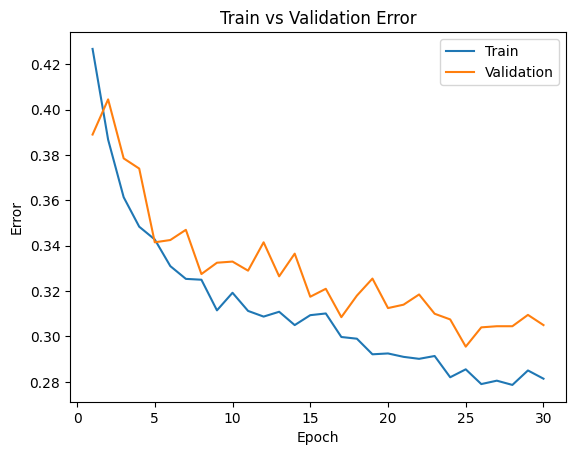

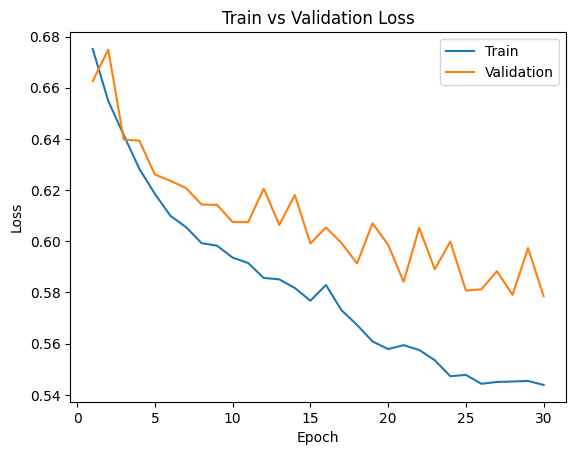

In [ ]:
small_path = get_model_name("small", batch_size= 64, learning_rate=0.01, epoch=29)
print("small net")
plot_training_curve(small_path)


large net


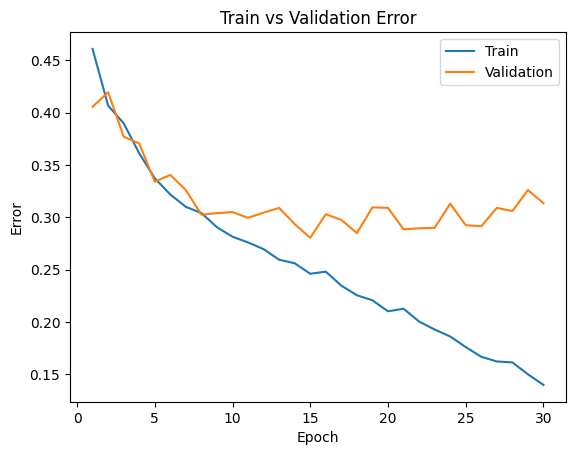

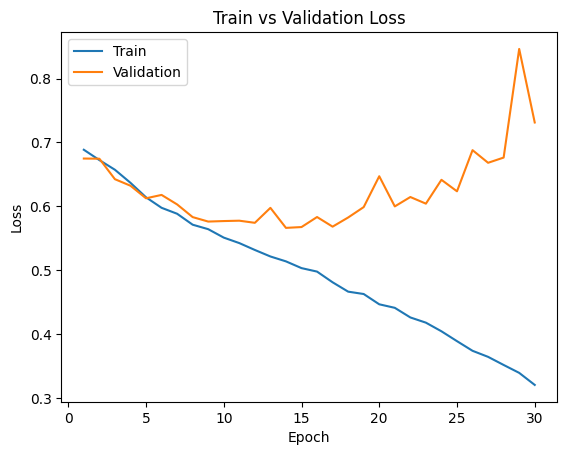

In [ ]:
large_path = get_model_name("large", batch_size = 64, learning_rate = 0.01, epoch = 29)
print("large net")
plot_training_curve(large_path)

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.001, num_epochs =30)
large_1 = get_model_name("large", batch_size= 64, learning_rate= 0.001, epoch = 29)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589712142945 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067280769348 |Validation err: 0.4285, Validation loss: 0.690854424610734
Epoch 4: Train err: 0.43, Train loss: 0.690861343383789 |Validation err: 0.424, Validation loss: 0.6896595880389214
Epoch 5: Train err: 0.434125, Train loss: 0.6899195008277893 |Validation err: 0.4195, Validation loss: 0.6886935643851757
Epoch 6: Train err: 0.43575, Train loss: 0.6887411961555481 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774147033691 |Validation err: 0.4185, Validation loss: 0.6851982977241278
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.412,

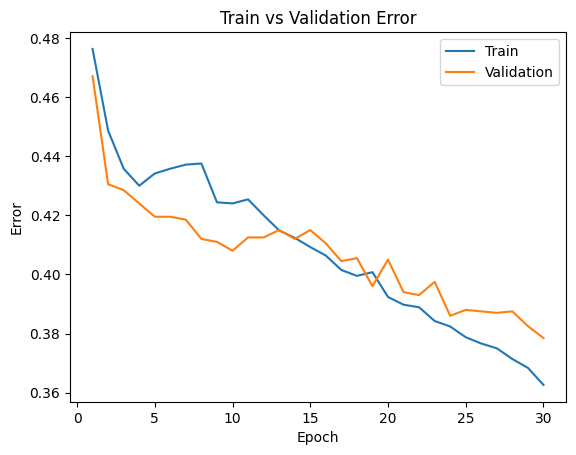

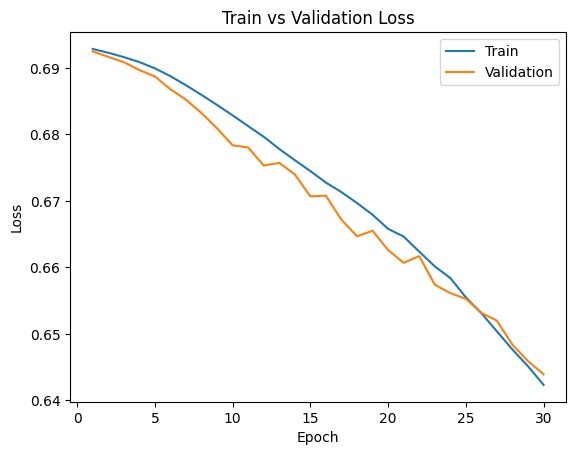

In [ ]:
plot_training_curve(large_1)

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size = 64, learning_rate = 0.1, num_epochs = 30)
large_2 = get_model_name("large", batch_size = 64, learning_rate = 0.1, epoch = 29)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

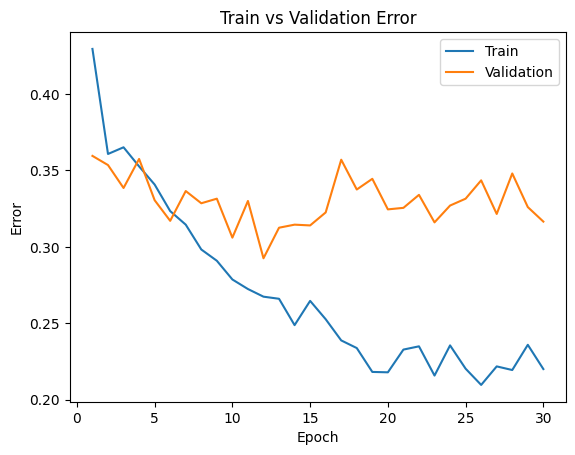

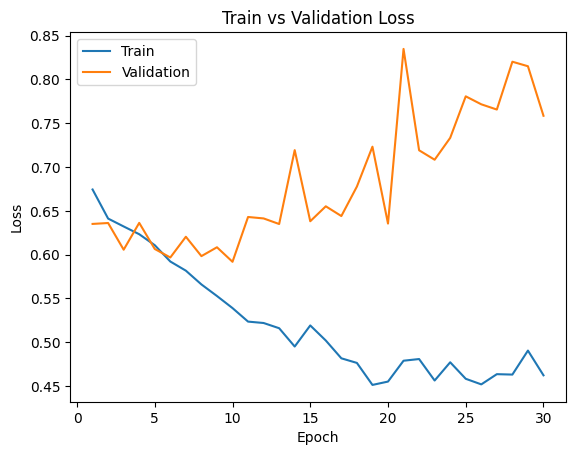

In [ ]:
plot_training_curve(large_2)

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size = 512, learning_rate = 0.01, num_epochs = 30)
large_3 = get_model_name("large", batch_size = 512, learning_rate = 0.01, epoch = 29)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

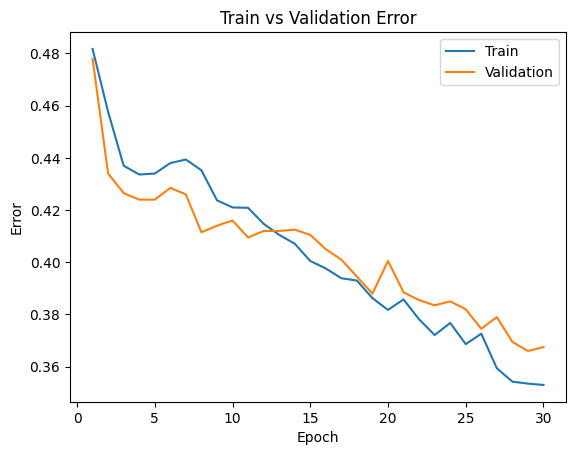

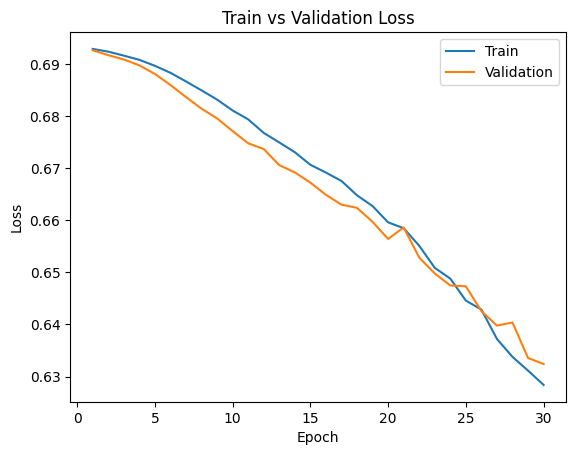

In [ ]:
print()
plot_training_curve(large_3)
print()

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size = 16, learning_rate = 0.01, num_epochs = 30)
large_4 = get_model_name("large", batch_size = 16, learning_rate = 0.01, epoch = 29)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

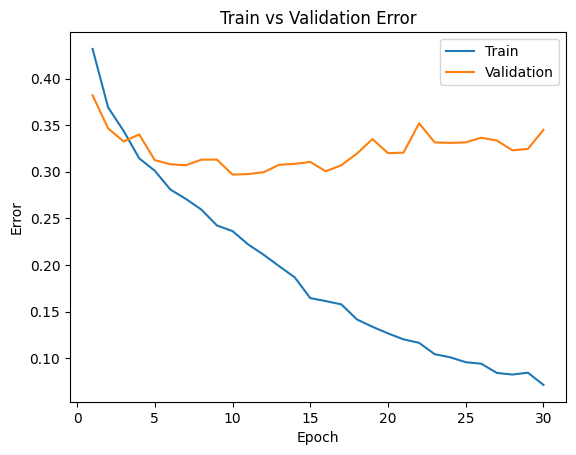

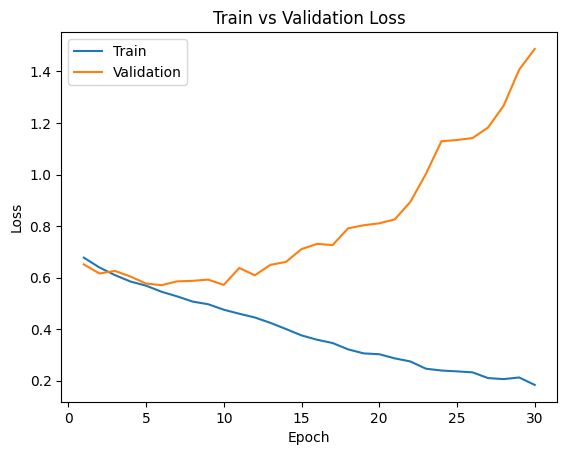

In [ ]:
print()
plot_training_curve(large_4)
print()

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size = 512, learning_rate = 0.001, num_epochs = 30)
large_5 = get_model_name("large", batch_size = 512, learning_rate = 0.001, epoch = 29)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48825, Train loss: 0.6930677480995655 |Validation err: 0.4955, Validation loss: 0.6931362152099609
Epoch 2: Train err: 0.483125, Train loss: 0.692995510995388 |Validation err: 0.4945, Validation loss: 0.6930360496044159
Epoch 3: Train err: 0.480375, Train loss: 0.6929280497133732 |Validation err: 0.493, Validation loss: 0.6929539889097214
Epoch 4: Train err: 0.477, Train loss: 0.6928808391094208 |Validation err: 0.4885, Validation loss: 0.692870706319809
Epoch 5: Train err: 0.473375, Train loss: 0.692774411290884 |Validation err: 0.4835, Validation loss: 0.6927504986524582
Epoch 6: Train err: 0.469, Train loss: 0.6926896274089813 |Validation err: 0.472, Validation loss: 0.6926551759243011
Epoch 7: Train err: 0.46325, Train loss: 0.692620363086462 |Validation err: 0.47, Validation loss: 0.6925524920225143
Epoch 8: Train err: 0.46225, Train loss: 0.6925435550510883 |Validation err: 0.463, Va

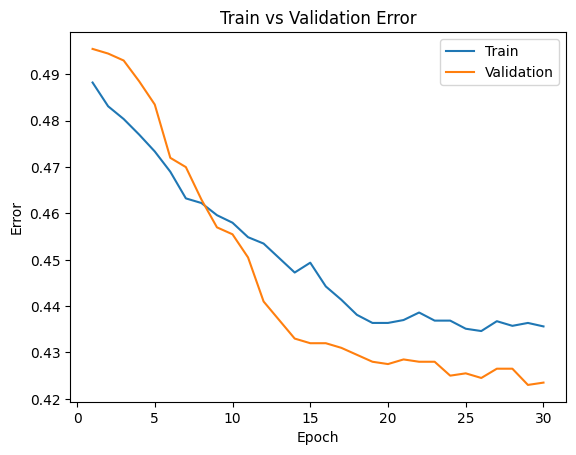

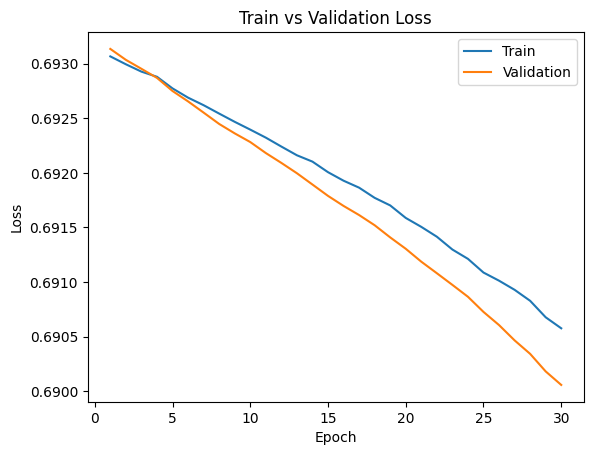

In [ ]:
print()
plot_training_curve(large_5)
print()

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size = 512, learning_rate = 0.01, num_epochs = 70)
large_6 = get_model_name("large", batch_size = 512, learning_rate = 0.01, epoch = 69)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.501625, Train loss: 0.6944856643676758 |Validation err: 0.4925, Validation loss: 0.6918851733207703
Epoch 2: Train err: 0.484375, Train loss: 0.6918258555233479 |Validation err: 0.4605, Validation loss: 0.6907174289226532
Epoch 3: Train err: 0.460625, Train loss: 0.6905319429934025 |Validation err: 0.4455, Validation loss: 0.689977377653122
Epoch 4: Train err: 0.45675, Train loss: 0.6893849335610867 |Validation err: 0.444, Validation loss: 0.6885365694761276
Epoch 5: Train err: 0.448875, Train loss: 0.6877013072371483 |Validation err: 0.4435, Validation loss: 0.6866696774959564
Epoch 6: Train err: 0.448375, Train loss: 0.6862502433359623 |Validation err: 0.4355, Validation loss: 0.68471360206604
Epoch 7: Train err: 0.442375, Train loss: 0.6843466758728027 |Validation err: 0.4355, Validation loss: 0.6823939234018326
Epoch 8: Train err: 0.4395, Train loss: 0.6822278089821339 |Validation err:

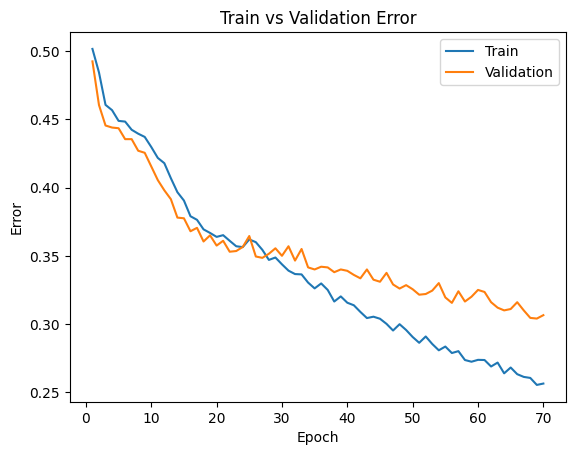

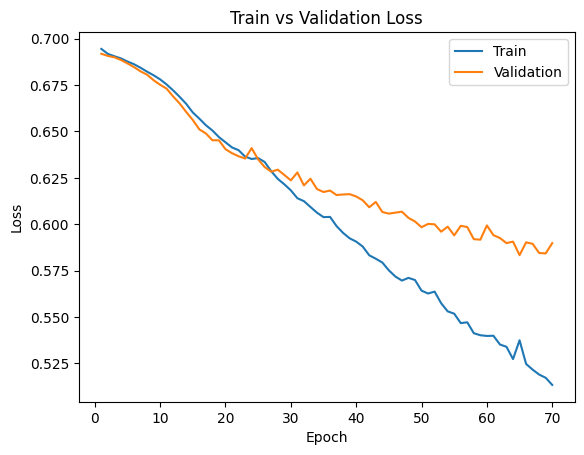

In [ ]:
print()
plot_training_curve(large_6)
print()

In [ ]:
net = LargeNet()
train_net(net, batch_size = 512, learning_rate = 0.01, num_epochs = 70)
large_6 = get_model_name("large", batch_size = 512, learning_rate = 0.01, epoch = 69)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.49775, Train loss: 0.6960508115589619 |Validation err: 0.509, Validation loss: 0.6955493688583374
Epoch 2: Train err: 0.495125, Train loss: 0.6931513398885727 |Validation err: 0.4955, Validation loss: 0.6927372068166733
Epoch 3: Train err: 0.453875, Train loss: 0.6918266415596008 |Validation err: 0.4595, Validation loss: 0.6917284578084946
Epoch 4: Train err: 0.442, Train loss: 0.6910673007369041 |Validation err: 0.4455, Validation loss: 0.6908131688833237
Epoch 5: Train err: 0.4415, Train loss: 0.6900645382702351 |Validation err: 0.4445, Validation loss: 0.6894948929548264
Epoch 6: Train err: 0.442625, Train loss: 0.6889603920280933 |Validation err: 0.438, Validation loss: 0.6878159940242767
Epoch 7: Train err: 0.44025, Train loss: 0.6874368563294411 |Validation err: 0.433, Validation loss: 0.6858795434236526
Epoch 8: Train err: 0.4415, Train loss: 0.6858387552201748 |Validation err: 0.42

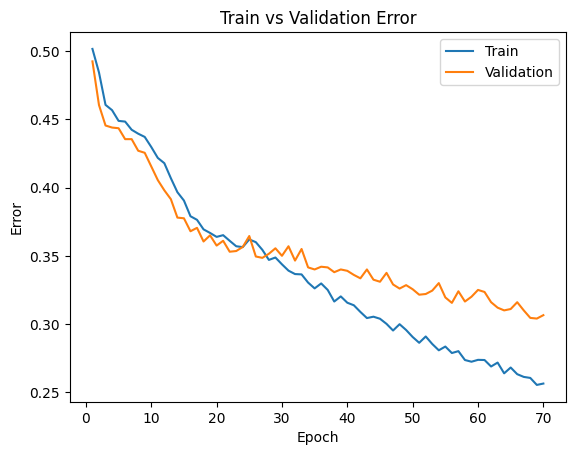

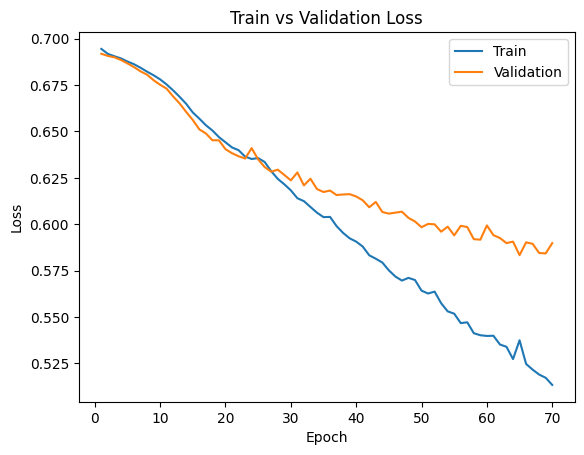

In [ ]:
print()
plot_training_curve(large_6)
print()

In [ ]:

state = torch.load(large_6)
net.load_state_dict(state)

<All keys matched successfully>

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=512)

criterion = nn.BCEWithLogitsLoss()
testError, testLoss = evaluate(net, test_loader, criterion)
print("The error  for the test set is " + str(testError))
print("The loss for the test set is " + str(testLoss))

Files already downloaded and verified
Files already downloaded and verified
The error  for the test set is 0.3055
The loss for the test set is 0.5713688135147095


In [ ]:
class ANN(nn.Module):
  def __init__(self):
    super(ANN,self).__init__()
    self.name = "ANN"
    self.layer1 = nn.Linear(3*32*32, 32)
    self.layer2 = nn.Linear(32,1)

  def forward(self,img):
    flattened = img.view(-1, 3*32*32)
    activation1 = self.layer1(flattened)
    activation1=F.relu(activation1)
    activation2 = self.layer2(activation1)
    final = activation2.squeeze(1)

    return final

In [ ]:
ANN_net = ANN()
train_net(ANN_net, batch_size = 512, learning_rate= 0.001, num_epochs = 30)
ANN_1 = get_model_name("ANN", batch_size = 512, learning_rate = 0.001, epoch = 29)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.518125, Train loss: 0.6957798972725868 |Validation err: 0.495, Validation loss: 0.6949406117200851
Epoch 2: Train err: 0.465875, Train loss: 0.6891722828149796 |Validation err: 0.446, Validation loss: 0.6880662739276886
Epoch 3: Train err: 0.431375, Train loss: 0.6834481209516525 |Validation err: 0.428, Validation loss: 0.6835118681192398
Epoch 4: Train err: 0.4205, Train loss: 0.6791877001523972 |Validation err: 0.421, Validation loss: 0.6799624413251877
Epoch 5: Train err: 0.413375, Train loss: 0.6752330027520657 |Validation err: 0.4155, Validation loss: 0.6770227402448654
Epoch 6: Train err: 0.407625, Train loss: 0.6724481470882893 |Validation err: 0.412, Validation loss: 0.6744281947612762
Epoch 7: Train err: 0.4015, Train loss: 0.6697544120252132 |Validation err: 0.414, Validation loss: 0.6723171770572662
Epoch 8: Train err: 0.399125, Train loss: 0.6673987507820129 |Validation err: 0.

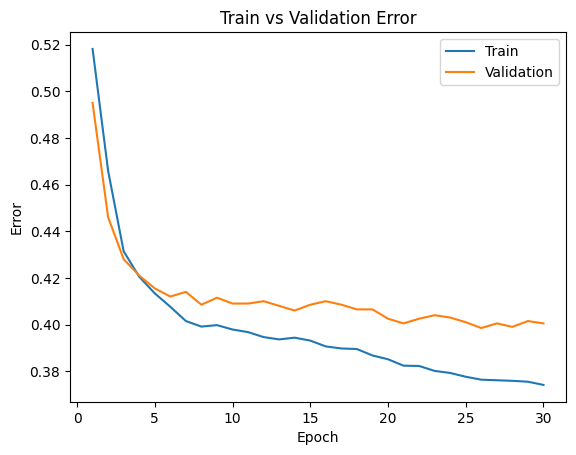

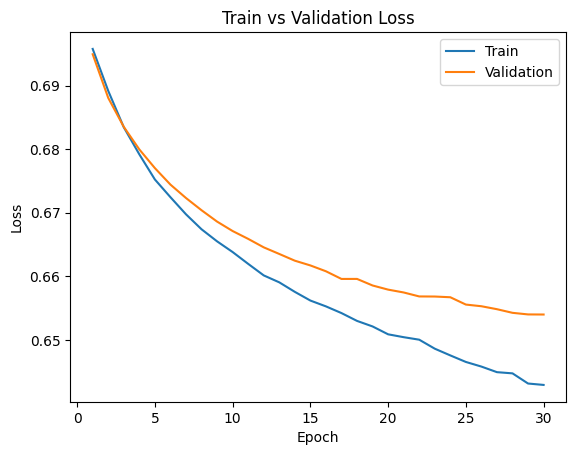

In [ ]:
print()
plot_training_curve(ANN_1)
print()

In [ ]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes = ["cat", "dog"],
    batch_size = 512
)

criterion = nn.BCEWithLogitsLoss()
testError, testLoss = evaluate(ANN_net, test_loader, criterion)

print("The error on the test set is " + str(testError))
print("The loss on the test set is " + str(testLoss))


Files already downloaded and verified
Files already downloaded and verified
The error on the test set is 0.38
The loss on the test set is 0.6477798670530319
